In [1]:
import os
import numpy as np 
import pandas as pd 
import librosa
import itertools
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
from copy import copy
from collections import OrderedDict

In [2]:
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
# Set the seed
np.random.seed(42)

In [5]:
dir = r'C:\Users\User\OneDrive\Desktop\research Upasana\Split'

In [6]:
song_samples = 1058
ragas = {'asavari':0,
         'bageshree':1,
         'Bhairavi':2,
         'bhoop':3,
         'DKanada':4,
         'malkauns':5,
         'sarang':6,
         'yaman':7}

In [7]:
# Get statistics from the vectors
def get_moments(descriptors):
    result = {}
    for k, v in descriptors.items():
        result['{}_max'.format(k)] = np.max(v)
        result['{}_min'.format(k)] = np.min(v)
        result['{}_mean'.format(k)] = np.mean(v)
        result['{}_std'.format(k)] = np.std(v)
        result['{}_kurtosis'.format(k)] = kurtosis(v)
        result['{}_skew'.format(k)] = skew(v)
    return result

In [8]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [9]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in ragas.items():
        folder = src_dir +'\\'+ x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "\\" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['raga'] = ragas[x]
                arr_features.append(features)
    return arr_features

In [10]:
%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(dir, debug=False)

Wall time: 33min 38s


In [11]:
df_features = pd.DataFrame(features)

In [12]:
df_features.shape

(1252, 134)

In [13]:
df_features.head()

,centroid_max,centroid_min,centroid_mean,centroid_std,centroid_kurtosis,centroid_skew,roloff_max,roloff_min,roloff_mean,roloff_std,...,mfcc_11_kurtosis,mfcc_11_skew,mfcc_12_max,mfcc_12_min,mfcc_12_mean,mfcc_12_std,mfcc_12_kurtosis,mfcc_12_skew,tempo,raga
0,2073.982055,964.770221,1171.337116,100.299005,15.296142,1.979773,4328.173828,1313.525391,1868.592413,285.351099,...,-0.034480,-0.018860,29.381794,-20.639980,7.335072,10.873636,-0.579042,-0.374615,117.453835,0
1,1504.468277,883.225115,1149.249471,111.021068,0.313219,0.589173,2670.117188,1335.058594,1763.174644,294.034289,...,-0.134276,0.016921,27.500496,-28.568312,-5.020803,10.777459,-0.412058,0.315966,172.265625,0
2,1510.494331,984.539104,1212.915395,114.032797,-0.864509,0.117347,2648.583984,1399.658203,1817.282437,273.815598,...,-0.225098,0.212718,26.891628,-32.471771,-7.612918,10.550886,-0.142515,0.452324,172.265625,0
3,1534.270752,929.865965,1138.171915,85.585473,1.699763,0.567919,3143.847656,1399.658203,1750.584465,279.741313,...,-0.178609,0.243193,16.349447,-24.276566,-4.581534,8.007316,-0.397369,0.057298,172.265625,0
4,1674.304462,918.171659,1193.111998,123.236465,0.523370,0.389244,3746.777344,1399.658203,1871.190387,324.795818,...,-0.136827,0.151055,16.993633,-30.525286,-3.450526,9.835612,-0.628334,-0.212860,172.265625,0


In [14]:
df_features.to_csv('raga_features.csv', index=False)

In [15]:
X = df_features.drop(['raga'], axis=1).values
y = df_features['raga'].values

### Visualization

In [16]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [17]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.8909


In [18]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

In [19]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1252 samples in 0.005s...
[t-SNE] Computed neighbors for 1252 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1252
[t-SNE] Computed conditional probabilities for sample 1252 / 1252
[t-SNE] Mean sigma: 3.130720
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.766647
[t-SNE] KL divergence after 1000 iterations: 0.698418


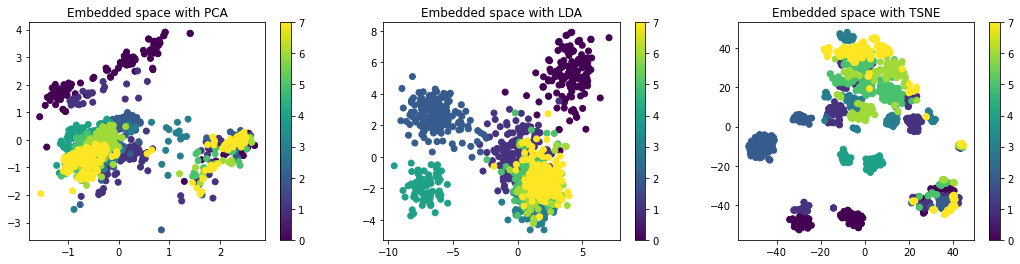

In [20]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

### Classical Machine Learning

In [21]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

LOGISTIC REGRESSION

In [23]:
params = {
    "cls__penalty": ["l1", "l2"],
    "cls__C": [0.5, 1, 2, 5],
    "cls__max_iter": [500]
}

pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.91054728        nan 0.912692          nan 0.90843099
        nan 0.90416999]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', LogisticRegression())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5], 'cls__max_iter': [500],
                         'cls__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [24]:
preds_lr = grid_lr.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_lr.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds_lr)))

best score on validation set (accuracy) = 0.9127
best score on test set (accuracy) = 0.9137


In [25]:
preds_lr

array([1, 3, 2, 0, 5, 7, 5, 2, 0, 7, 0, 1, 6, 6, 3, 1, 4, 5, 6, 0, 6, 5,
       4, 7, 0, 2, 2, 5, 1, 3, 7, 6, 3, 4, 1, 3, 4, 3, 0, 7, 3, 3, 3, 1,
       6, 7, 6, 3, 5, 4, 3, 1, 1, 5, 1, 1, 1, 2, 6, 2, 5, 7, 2, 1, 3, 2,
       2, 1, 7, 1, 3, 1, 0, 7, 6, 5, 2, 6, 6, 0, 5, 2, 2, 5, 5, 1, 5, 7,
       4, 0, 7, 3, 0, 0, 7, 7, 7, 7, 1, 1, 5, 2, 0, 4, 3, 0, 1, 1, 4, 5,
       6, 5, 3, 1, 2, 3, 0, 2, 5, 1, 7, 3, 2, 3, 3, 1, 1, 4, 2, 1, 4, 0,
       4, 4, 2, 1, 1, 0, 0, 0, 2, 2, 1, 2, 6, 1, 6, 7, 1, 3, 0, 5, 1, 0,
       4, 7, 7, 2, 2, 6, 6, 3, 7, 5, 5, 1, 5, 7, 1, 6, 2, 6, 1, 5, 4, 7,
       2, 4, 1, 6, 7, 1, 7, 5, 2, 0, 1, 1, 0, 0, 6, 1, 2, 1, 7, 5, 7, 7,
       1, 5, 4, 1, 5, 7, 7, 6, 2, 0, 1, 2, 1, 1, 1, 3, 0, 3, 2, 7, 1, 0,
       5, 6, 6, 0, 1, 2, 5, 6, 6, 1, 4, 2, 1, 1, 3, 2, 7, 0, 1, 6, 5, 6,
       6, 7, 7, 5, 7, 0, 5, 0, 2, 7, 6, 3, 6, 1, 5, 5, 2, 3, 7, 4, 7, 3,
       1, 1, 7, 3, 7, 3, 6, 0, 4, 5, 3, 2, 1, 6, 3, 5, 0, 1, 0, 7, 6, 6,
       6, 1, 0, 2, 4, 4, 1, 2, 5, 6, 7, 2, 0, 2, 1,

ELASTICNET

In [26]:
params = {
    "cls__loss": ['log'],
    "cls__penalty": ["elasticnet"],
    "cls__l1_ratio": [0.15, 0.25, 0.5, 0.75],
}

pipe_en = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SGDClassifier())
])

grid_en = GridSearchCV(pipe_en, params, scoring='accuracy', n_jobs=6, cv=5)
grid_en.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SGDClassifier())]),
             n_jobs=6,
             param_grid={'cls__l1_ratio': [0.15, 0.25, 0.5, 0.75],
                         'cls__loss': ['log'], 'cls__penalty': ['elasticnet']},
             scoring='accuracy')

In [27]:
preds_en = grid_en.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_en.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds_en)))

best score on validation set (accuracy) = 0.8925
best score on test set (accuracy) = 0.8658


CART

In [28]:
params = {
    "cls__criterion": ["gini", "entropy"],
    "cls__splitter": ["best", "random"],
}

pipe_cart = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', DecisionTreeClassifier())
])

grid_cart = GridSearchCV(pipe_cart, params, scoring='accuracy', n_jobs=6, cv=5)
grid_cart.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', DecisionTreeClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__splitter': ['best', 'random']},
             scoring='accuracy')

In [29]:
preds_cart = grid_cart.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_cart.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds_cart)))

best score on validation set (accuracy) = 0.8424
best score on test set (accuracy) = 0.8211


RANDOM FOREST

In [30]:
params = {
    "cls__n_estimators": [100, 250, 500, 1000],
    "cls__criterion": ["gini", "entropy"],
    "cls__max_depth": [5, 7, None]
}

pipe_rf = Pipeline([
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', RandomForestClassifier())
])

grid_rf = GridSearchCV(pipe_rf, params, scoring='accuracy', n_jobs=6, cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', RandomForestClassifier())]),
             n_jobs=6,
             param_grid={'cls__criterion': ['gini', 'entropy'],
                         'cls__max_depth': [5, 7, None],
                         'cls__n_estimators': [100, 250, 500, 1000]},
             scoring='accuracy')

In [31]:
preds_rf = grid_rf.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_rf.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds_rf)))

best score on validation set (accuracy) = 0.9574
best score on test set (accuracy) = 0.9521


SVM

In [32]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier())),
                                       ('cls', SVC())]),
             n_jobs=6,
             param_grid={'cls__C': [0.5, 1, 2, 5],
                         'cls__kernel': ['rbf', 'linear', 'sigmoid']},
             scoring='accuracy')

In [33]:
preds_svm = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds_svm)))

best score on validation set (accuracy) = 0.9649
best score on test set (accuracy) = 0.9808


In [34]:
preds_svm

array([1, 3, 2, 0, 5, 7, 5, 2, 0, 7, 0, 1, 6, 6, 3, 5, 4, 5, 6, 0, 6, 5,
       4, 7, 0, 2, 2, 5, 5, 3, 7, 6, 1, 4, 1, 3, 4, 3, 0, 7, 3, 3, 3, 1,
       6, 7, 6, 3, 5, 4, 3, 1, 1, 5, 1, 1, 1, 2, 6, 2, 5, 7, 2, 1, 3, 2,
       2, 1, 7, 2, 3, 1, 0, 7, 6, 5, 2, 6, 6, 0, 5, 2, 2, 5, 1, 1, 5, 7,
       4, 0, 7, 3, 0, 0, 7, 7, 7, 7, 1, 1, 5, 2, 0, 4, 3, 0, 1, 1, 4, 1,
       6, 5, 3, 1, 2, 3, 0, 2, 5, 1, 7, 3, 2, 3, 3, 1, 1, 4, 2, 1, 4, 0,
       4, 4, 2, 7, 1, 0, 0, 7, 2, 2, 1, 2, 6, 7, 6, 7, 1, 3, 0, 5, 0, 0,
       4, 7, 7, 2, 2, 6, 6, 3, 6, 5, 5, 1, 5, 7, 1, 6, 2, 6, 1, 5, 4, 7,
       2, 4, 1, 6, 7, 0, 7, 5, 2, 0, 1, 1, 0, 0, 6, 1, 2, 7, 7, 5, 7, 7,
       3, 5, 4, 1, 5, 7, 7, 6, 2, 0, 1, 2, 1, 1, 1, 5, 0, 3, 2, 7, 1, 0,
       5, 6, 6, 5, 6, 2, 5, 6, 5, 1, 4, 2, 1, 1, 3, 2, 7, 0, 5, 6, 7, 6,
       6, 7, 7, 5, 7, 0, 5, 0, 2, 7, 6, 3, 6, 1, 5, 5, 2, 3, 7, 4, 7, 5,
       1, 1, 7, 3, 7, 3, 6, 0, 4, 5, 3, 2, 1, 6, 3, 5, 0, 1, 0, 7, 5, 6,
       6, 1, 0, 2, 4, 4, 1, 2, 5, 6, 7, 2, 0, 2, 1,